In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.input_area pre {font-family: Consolas; font-size: 15pt; line-height: 140%; font-weight: bold}</style>"))
display(HTML("<style>.output_area pre {font-family: Consolas; font-size: 15pt; line-height: 140%;}</style>"))

In [1]:
import pickle
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import preprocessing
import pandas as pd
import os
import time, os
import pymysql
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import ta
import warnings

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 600)

warnings.filterwarnings(action='ignore')



%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15,7)

Populating the interactive namespace from numpy and matplotlib


# ccI

## train data 생성 함수

In [2]:
def make_data_train_cci(trading=100000000, cci_d='_', cci_u='_', days=10, label=0.02): 
    # traiding: 거래대금 임계값, ma: 이동평균 20일 범위, days: 일 수, label: next_chang 임계 값
    
    # 코드 리스트 
    IF=open("../data/code_list.txt", 'r')
    lst_code = IF.readlines()
    
    # trainX, trainY
    lst_trainX = []
    lst_trainY = []
    
    # next_change, code, date
    lst_nc = []  
    lst_cd = []
    lst_dt = []
    
    # database
    db_dsml = pymysql.connect(

    )
    cursor = db_dsml.cursor()
    
    
    col_scaling = ['Open', 'High', 'Low', 'Close', 'Trading', 'MA5', 'MA20', 'MA60', 'MA120', 
               'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
               'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD']   

    col_no_scaling = ['Change', 'Volume', 'MFI', 'ADI', 'OBV','CMF', 'FI', 'EOM, EMV', 
                      'VPT', 'NVI', 'ATR', 'UI', 'ADX', '-VI', '+VI', 'TRIX', 'MI', 
                      'CCI', 'DPO', 'KST', 'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
                       'WR', 'AO', 'ROC', 'PPO', 'PVO']
       
    temp_cci_d, temp_cci_u = cci_d, cci_u
    
    for line in tqdm(lst_code): 
        code = line.strip()
        sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date BETWEEN '2017-01-01' AND '2020-12-31'
                    '''.format(code)

        stock = pd.read_sql(sql=sql_query, con=db_dsml)
        stock['BeforeClose'] = stock['Close'].shift(1) # 전날 종가 컬럼 추가
        stock.dropna(inplace=True) # nan 제거 
        lst_stock = stock.values.tolist()

        if temp_cci_d == '_': 
            cci_d = stock['CCI'].min()
        if temp_cci_u == '_':
            cci_u = stock['CCI'].max()
        
        # scaling 필요 컬럼: 전날 종가로 나누어 스케일링
        stock['Trading'] = stock['Close'] * stock['Volume'] # 거래대금 컬럼 추가 
        scale_stock = stock[col_scaling].apply(lambda x: x/stock['BeforeClose'])
        lst_scale = scale_stock.values.tolist()

        # sclaling 필요x 컬럼 
        no_scale_stock = stock[col_no_scaling]
        lst_no_scale = no_scale_stock.values.tolist()        
        
        for i, row in enumerate(lst_stock): 
            date, close, volume, cci_ = row[0].strftime('%Y%m%d'), row[4], row[5], row[40]
            # 거래대금, cci 범위 조건

            if (close * volume >= trading) & ((cci_ >= cci_d) & (cci_ <= cci_u)):
                if i < (days-1):   # 예외 처리 
                    continue                               
                result=[]
                for row2, row3 in zip(lst_scale[i-(days-1):i+1], lst_no_scale[i-(days-1):i+1]):  # scaling, no scaling 
                    result += row2+row3 # scaling + no scaling                 
                y = int(row[7]>=label) # next change 사용   
                
                lst_trainX.append(result)
                lst_trainY.append(y)
                lst_nc.append(row[7])
                lst_cd.append(code)
                lst_dt.append(date)
    
    return np.array(lst_trainX), np.array(lst_trainY), np.array(lst_nc), lst_cd, lst_dt 

## test data 생성 함수 

In [3]:
def make_data_test_cci(trading=100000000, cci_d='_', cci_u='_', days=10, label=0.02): 
    # traiding: 거래대금 임계값, ma: 이동평균 20일 범위, days: 일 수, label: next_chang 임계 값
    
    # 코드 리스트 
    IF=open("../data/code_list.txt", 'r')
    lst_code = IF.readlines()
    
    # testX, testY
    lst_testX = []
    lst_testY = []
    
    # next_change
    lst_nc_test = []
    lst_cd_test = []
    lst_dt_test = []
    
    # database
    db_dsml = pymysql.connect(

    )
    cursor = db_dsml.cursor()
    
    
    col_scaling = ['Open', 'High', 'Low', 'Close', 'Trading', 'MA5', 'MA20', 'MA60', 'MA120', 
               'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
               'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD']   

    col_no_scaling = ['Change', 'Volume', 'MFI', 'ADI', 'OBV','CMF', 'FI', 'EOM, EMV', 
                      'VPT', 'NVI', 'ATR', 'UI', 'ADX', '-VI', '+VI', 'TRIX', 'MI', 
                      'CCI', 'DPO', 'KST', 'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
                       'WR', 'AO', 'ROC', 'PPO', 'PVO']
    
    temp_cci_d, temp_cci_u = cci_d, cci_u
    
    for line in tqdm(lst_code): 
        code = line.strip()
        sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date BETWEEN '2021-01-01' AND '2021-12-31'
                    '''.format(code)

        stock = pd.read_sql(sql=sql_query, con=db_dsml)
        stock['BeforeClose'] = stock['Close'].shift(1) # 전날 종가 컬럼 추가
        stock.dropna(inplace=True) # nan 제거 
        lst_stock = stock.values.tolist()
        
        if temp_cci_d == '_': 
            cci_d = stock['CCI'].min()
        if temp_cci_u == '_':
            cci_u = stock['CCI'].max()        
        
        # scaling 필요 컬럼: 전날 종가로 나누어 스케일링
        stock['Trading'] = stock['Close'] * stock['Volume'] # 거래대금 컬럼 추가 
        scale_stock = stock[col_scaling].apply(lambda x: x/stock['BeforeClose'])
        lst_scale = scale_stock.values.tolist()

        # sclaling 필요x 컬럼 
        no_scale_stock = stock[col_no_scaling]
        lst_no_scale = no_scale_stock.values.tolist()        
        
        for i, row in enumerate(lst_stock): 
            date, close, volume, cci_ = row[0].strftime('%Y%m%d'), row[4], row[5], row[40]
            # 거래대금, cci 범위 조건
            if (close * volume >= trading) & ((cci_ >= cci_d) & (cci_ <= cci_u)):
                if i < (days-1):   # 예외 처리 
                    continue                               

                result=[]
                for row2, row3 in zip(lst_scale[i-(days-1):i+1], lst_no_scale[i-(days-1):i+1]):  # scaling, no scaling 
                    result += row2+row3 # scaling + no scaling                 
                y = int(row[7]>=label) # next change 사용   
                
                lst_testX.append(result)
                lst_testY.append(y)
                lst_nc_test.append(row[7])
                lst_cd_test.append(code)
                lst_dt_test.append(date)
    
    return np.array(lst_testX), np.array(lst_testY), np.array(lst_nc_test), lst_cd_test, lst_dt_test

In [5]:
def plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob):
    from sklearn.metrics import roc_curve, roc_auc_score, f1_score, f1_score, accuracy_score, recall_score, precision_score
    
    fpr, tpr, thresholds = roc_curve(testY, test_prob) # output 3개가 나오는데, 각 threshhold 마다의 fpr, tpr값 인듯
    
    train_f1 = f1_score(trainY, train_pred)
    test_f1 = f1_score(testY, test_pred)
    
    train_recall = recall_score(trainY, train_pred)
    test_recall = recall_score(testY, test_pred)
    
    
    train_pre = precision_score(trainY, train_pred)
    test_pre = precision_score(testY, test_pred)  
    
    train_acc = accuracy_score(trainY, train_pred)
    test_acc = accuracy_score(testY, test_pred)
    
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(testY, test_prob),3)),fontsize=25)
    plt.legend()
    plt.show()
    print('train_f1 score: ',train_f1)
    print('test_f1 score: ',test_f1,'\n')
    
    print('train_recall score: ',train_recall)
    print('test_recall score: ',test_recall,'\n')

    print('train_pre score: ',train_pre)
    print('test_pre score: ',test_pre,'\n')
    
    print('train acc score: ',train_acc)
    print('test acc score: ',test_acc, '\n')

# CCI  -20~20

## 데이터 생성

In [7]:
trainX, trainY, lst_nc, lst_cd, lst_dt = make_data_train_cci(trading=100000000, cci_d=-20, cci_u=20, days=10, label=0.02)
testX, testY, lst_nc_test, lst_cd_test, lst_dt_test = make_data_test_cci(trading=100000000, cci_d=-20, cci_u=20, days=10, label=0.02)

100%|█████████████████████████████████████████| 1561/1561 [00:50<00:00, 30.65it/s]


In [8]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(123321, 560)
(123321,)
(36885, 560)
(36885,)


## PARAMETER

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
                   n_jobs=40,
                   scale_pos_weight=4,
                   learning_rate=0.01,
                   max_depth=3,
                   n_estimators=800,
                   ) # 임의의 값 (튜닝값 x)

xgb_model.fit(trainX, trainY)

train_prob = xgb_model.predict_proba(trainX)[:, 1]
train_pred = xgb_model.predict(trainX)
test_prob = xgb_model.predict_proba(testX)[:, 1]
test_pred = xgb_model.predict(testX)

plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob)

### 모델 저장 

In [30]:
import pickle
pickle.dump(xgb_model, open('xgb.model', 'wb'))

--------

### 모델 로드 

In [9]:
xgb_model = pickle.load(open('xgb.model', 'rb'))

train_prob = xgb_model.predict_proba(trainX)[:, 1]
train_pred = xgb_model.predict(trainX)
test_prob = xgb_model.predict_proba(testX)[:, 1]
test_pred = xgb_model.predict(testX)

# Shap Value

In [10]:
# 컬럼 리스트 생성
lst_col_info = []
# 컬럼 리스트 생성
lst_col_info = []

for day in range(9, -1, -1): 
    lst_col_info += 'D-{0}_Open,D-{0}_High,D-{0}_Low,D-{0}_Close,D-{0}_Trading,D-{0}_MA5,D-{0}_MA20,D-{0}_MA60,D-{0}_MA120,D-{0}_VMAP,D-{0}_BHB,D-{0}_BLB,D-{0}_KCH,D-{0}_KCL,D-{0}_KCM,D-{0}_DCH,D-{0}_DCL,D-{0}_DCM,D-{0}_SMA,D-{0}_EMA,D-{0}_WMA,D-{0}_Ichimoku,D-{0}_Parabolic SAR,D-{0}_KAMA,D-{0}_MACD,D-{0}_Change,D-{0}_Volume,D-{0}_MFI,D-{0}_ADI,D-{0}_OBV,D-{0}_CMF,D-{0}_FI,D-{0}_EOM_EMV,D-{0}_VPT,D-{0}_NVI,D-{0}_ATR,D-{0}_UI,D-{0}_ADX,D-{0}_-VI,D-{0}_+VI,D-{0}_TRIX,D-{0}_MI,D-{0}_CCI,D-{0}_DPO,D-{0}_KST,D-{0}_STC,D-{0}_RSI,D-{0}_SRSI,D-{0}_TSI,D-{0}_UO,D-{0}_SR,D-{0}_WR,D-{0}_AO,D-{0}_ROC,D-{0}_PPO,D-{0}_PVO'.format(day).split(',')

In [11]:
##### train
df_trainX = pd.DataFrame(trainX)
df_trainX.columns = lst_col_info
df_trainY = pd.DataFrame(trainY)

##### test 
df_testX = pd.DataFrame(testX)
df_testX.columns = lst_col_info
df_testY = pd.DataFrame(testY)

df_trainX.head()

,D-9_Open,D-9_High,D-9_Low,D-9_Close,D-9_Trading,D-9_MA5,D-9_MA20,D-9_MA60,D-9_MA120,D-9_VMAP,D-9_BHB,D-9_BLB,D-9_KCH,D-9_KCL,D-9_KCM,D-9_DCH,D-9_DCL,D-9_DCM,D-9_SMA,D-9_EMA,D-9_WMA,D-9_Ichimoku,D-9_Parabolic SAR,D-9_KAMA,D-9_MACD,D-9_Change,D-9_Volume,D-9_MFI,D-9_ADI,D-9_OBV,D-9_CMF,D-9_FI,D-9_EOM_EMV,D-9_VPT,D-9_NVI,D-9_ATR,D-9_UI,D-9_ADX,D-9_-VI,D-9_+VI,D-9_TRIX,D-9_MI,D-9_CCI,D-9_DPO,D-9_KST,D-9_STC,D-9_RSI,D-9_SRSI,D-9_TSI,D-9_UO,...,D-0_MA20,D-0_MA60,D-0_MA120,D-0_VMAP,D-0_BHB,D-0_BLB,D-0_KCH,D-0_KCL,D-0_KCM,D-0_DCH,D-0_DCL,D-0_DCM,D-0_SMA,D-0_EMA,D-0_WMA,D-0_Ichimoku,D-0_Parabolic SAR,D-0_KAMA,D-0_MACD,D-0_Change,D-0_Volume,D-0_MFI,D-0_ADI,D-0_OBV,D-0_CMF,D-0_FI,D-0_EOM_EMV,D-0_VPT,D-0_NVI,D-0_ATR,D-0_UI,D-0_ADX,D-0_-VI,D-0_+VI,D-0_TRIX,D-0_MI,D-0_CCI,D-0_DPO,D-0_KST,D-0_STC,D-0_RSI,D-0_SRSI,D-0_TSI,D-0_UO,D-0_SR,D-0_WR,D-0_AO,D-0_ROC,D-0_PPO,D-0_PVO
0,1.005714,1.048000,1.000000,1.040000,462369.440000,0.994514,0.968971,0.981010,1.040524,0.993304,1.023299,0.914644,1.001962,0.936476,0.969219,1.048000,0.899429,1.001143,0.985714,0.985297,0.993498,0.974000,1.005851,0.971480,0.013280,0.040000,444586.0,85.453413,2.060672e+06,21755882.0,0.089438,2.701072e+07,1.653223e+07,19930.995041,807.817052,302.020489,1.499345,21.745077,0.770202,1.148990,0.100130,24.514658,195.248701,71.5,45.713527,99.999930,70.238205,1.000000,15.661673,49.477868,...,0.987640,0.954307,1.015178,1.002500,1.038215,0.937066,1.020112,0.957865,0.988989,1.044944,0.938202,1.009551,1.004963,0.997665,1.005493,0.992697,1.043708,0.990598,0.015949,-0.011236,95832.0,71.030604,1.874693e+06,21487295.0,-0.017311,3.831412e+06,-2.582645e+07,-1951.917720,782.173035,282.828044,1.728384,23.669539,0.924242,1.080808,0.276289,24.359480,7.219402,-160.0,80.495616,50.000000,52.767201,0.057077,20.137832,43.856662,46.236559,-53.763441,433.235294,2.564103,1.624561,-3.039166
1,1.000000,1.011236,0.974157,0.988764,94755.235955,1.004719,0.987640,0.954307,1.015178,1.002500,1.038215,0.937066,1.020112,0.957865,0.988989,1.044944,0.938202,1.009551,1.004963,0.997665,1.005493,0.992697,1.043708,0.990598,0.015949,-0.011236,95832.0,71.030604,1.874693e+06,21487295.0,-0.017311,3.831412e+06,-2.582645e+07,-1951.917720,782.173035,282.828044,1.728384,23.669539,0.924242,1.080808,0.276289,24.359480,7.219402,-160.0,80.495616,50.000000,52.767201,0.057077,20.137832,43.856662,...,0.998867,0.962307,1.014572,0.999311,1.052563,0.945172,1.034730,0.965194,0.999962,1.053228,0.942242,0.986410,0.985089,0.990911,0.988222,0.992072,1.019142,0.970770,0.005230,0.013590,64534.0,55.405889,1.716323e+06,21422435.0,-0.026841,3.612700e+06,-3.409056e+07,-4279.907251,767.592212,302.522632,4.857345,20.015463,1.040380,0.959620,0.095439,25.570330,19.057765,160.0,31.513157,22.613092,58.029378,0.779487,6.199506,48.326356,75.903614,-24.096386,53.588235,-0.885936,0.530558,2.429462
2,1.007463,1.012793,0.996802,1.005330,105709.495736,0.974840,0.944350,0.910856,0.953198,0.950598,1.005155,0.883544,0.975409,0.914534,0.944972,1.012793,0.886994,0.949893,0.945629,0.959599,0.972329,0.950693,0.959384,0.956361,0.015937,0.005330,105149.0,84.843280,1.862021e+06,21664705.0,-0.024944,1.173309e+07,3.423713e+07,6746.013357,769.959421,289.332097,4.682768,24.144421,0.881797,1.160757,0.140746,25.405072,182.131974,-428.0,30.971582,96.437652,68.784853,1.000000,18.642720,51.178165,...,0.996187,0.946659,0.975572,1.017091,1.077916,0.914459,1.032789,0.957625,0.995207,1.062092,0.906318,1.016885,1.023784,1.010177,1.017236,1.000545,1.055877,1.013671,0.016356,-0.021786,309661.0,64.649314,2.053747e+06,21675051.0,0.090754,-7.844796e+06,-3.342365e+07,-10889.587143,729.174605,343.408485,3.184214,28.605201,0.904858,1.024291,0.308034,25.875561,-10.043668,-65.0,75.677091,34.861536,46.479620,0.000000,16.267954,46.534386,14.444444,-85.555556,343.500000,0.898876,1.645809,10.986297
3,1.007423,1.033934,0.975610,1.033934,327239.156946,0.987063,0.943160,0.907971,0.948206,0.958880,1.016118,0.870202,0.974973,0.910710,0.942842,1.033934,0.882291,0.959703,0.952280,0.966730,0.982774,0.9660

In [12]:
##### train
df_trainX_cd = df_trainX.copy()
df_trainX_cd['Code'] = lst_cd
df_trainX_cd['Date'] = lst_dt
df_trainX_cd = df_trainX_cd[['Code', 'Date']+lst_col_info]


##### test
df_testX_cd = df_testX.copy()
df_testX_cd['Code'] = lst_cd_test
df_testX_cd['Date'] = lst_dt_test
df_testX_cd = df_testX_cd[['Code', 'Date']+lst_col_info]

df_trainX_cd.head()

,Code,Date,D-9_Open,D-9_High,D-9_Low,D-9_Close,D-9_Trading,D-9_MA5,D-9_MA20,D-9_MA60,D-9_MA120,D-9_VMAP,D-9_BHB,D-9_BLB,D-9_KCH,D-9_KCL,D-9_KCM,D-9_DCH,D-9_DCL,D-9_DCM,D-9_SMA,D-9_EMA,D-9_WMA,D-9_Ichimoku,D-9_Parabolic SAR,D-9_KAMA,D-9_MACD,D-9_Change,D-9_Volume,D-9_MFI,D-9_ADI,D-9_OBV,D-9_CMF,D-9_FI,D-9_EOM_EMV,D-9_VPT,D-9_NVI,D-9_ATR,D-9_UI,D-9_ADX,D-9_-VI,D-9_+VI,D-9_TRIX,D-9_MI,D-9_CCI,D-9_DPO,D-9_KST,D-9_STC,D-9_RSI,D-9_SRSI,...,D-0_MA20,D-0_MA60,D-0_MA120,D-0_VMAP,D-0_BHB,D-0_BLB,D-0_KCH,D-0_KCL,D-0_KCM,D-0_DCH,D-0_DCL,D-0_DCM,D-0_SMA,D-0_EMA,D-0_WMA,D-0_Ichimoku,D-0_Parabolic SAR,D-0_KAMA,D-0_MACD,D-0_Change,D-0_Volume,D-0_MFI,D-0_ADI,D-0_OBV,D-0_CMF,D-0_FI,D-0_EOM_EMV,D-0_VPT,D-0_NVI,D-0_ATR,D-0_UI,D-0_ADX,D-0_-VI,D-0_+VI,D-0_TRIX,D-0_MI,D-0_CCI,D-0_DPO,D-0_KST,D-0_STC,D-0_RSI,D-0_SRSI,D-0_TSI,D-0_UO,D-0_SR,D-0_WR,D-0_AO,D-0_ROC,D-0_PPO,D-0_PVO
0,050120,20170120,1.005714,1.048000,1.000000,1.040000,462369.440000,0.994514,0.968971,0.981010,1.040524,0.993304,1.023299,0.914644,1.001962,0.936476,0.969219,1.048000,0.899429,1.001143,0.985714,0.985297,0.993498,0.974000,1.005851,0.971480,0.013280,0.040000,444586.0,85.453413,2.060672e+06,21755882.0,0.089438,2.701072e+07,1.653223e+07,19930.995041,807.817052,302.020489,1.499345,21.745077,0.770202,1.148990,0.100130,24.514658,195.248701,71.5,45.713527,99.999930,70.238205,1.000000,...,0.987640,0.954307,1.015178,1.002500,1.038215,0.937066,1.020112,0.957865,0.988989,1.044944,0.938202,1.009551,1.004963,0.997665,1.005493,0.992697,1.043708,0.990598,0.015949,-0.011236,95832.0,71.030604,1.874693e+06,21487295.0,-0.017311,3.831412e+06,-2.582645e+07,-1951.917720,782.173035,282.828044,1.728384,23.669539,0.924242,1.080808,0.276289,24.359480,7.219402,-160.0,80.495616,50.000000,52.767201,0.057077,20.137832,43.856662,46.236559,-53.763441,433.235294,2.564103,1.624561,-3.039166
1,050120,20170206,1.000000,1.011236,0.974157,0.988764,94755.235955,1.004719,0.987640,0.954307,1.015178,1.002500,1.038215,0.937066,1.020112,0.957865,0.988989,1.044944,0.938202,1.009551,1.004963,0.997665,1.005493,0.992697,1.043708,0.990598,0.015949,-0.011236,95832.0,71.030604,1.874693e+06,21487295.0,-0.017311,3.831412e+06,-2.582645e+07,-1951.917720,782.173035,282.828044,1.728384,23.669539,0.924242,1.080808,0.276289,24.359480,7.219402,-160.0,80.495616,50.000000,52.767201,0.057077,...,0.998867,0.962307,1.014572,0.999311,1.052563,0.945172,1.034730,0.965194,0.999962,1.053228,0.942242,0.986410,0.985089,0.990911,0.988222,0.992072,1.019142,0.970770,0.005230,0.013590,64534.0,55.405889,1.716323e+06,21422435.0,-0.026841,3.612700e+06,-3.409056e+07,-4279.907251,767.592212,302.522632,4.857345,20.015463,1.040380,0.959620,0.095439,25.570330,19.057765,160.0,31.513157,22.613092,58.029378,0.779487,6.199506,48.326356,75.903614,-24.096386,53.588235,-0.885936,0.530558,2.429462
2,050120,20170224,1.007463,1.012793,0.996802,1.005330,105709.495736,0.974840,0.944350,0.910856,0.953198,0.950598,1.005155,0.883544,0.975409,0.914534,0.944972,1.012793,0.886994,0.949893,0.945629,0.959599,0.972329,0.950693,0.959384,0.956361,0.015937,0.005330,105149.0,84.843280,1.862021e+06,21664705.0,-0.024944,1.173309e+07,3.423713e+07,6746.013357,769.959421,289.332097,4.682768,24.144421,0.881797,1.160757,0.140746,25.405072,182.131974,-428.0,30.971582,96.437652,68.784853,1.000000,...,0.996187,0.946659,0.975572,1.017091,1.077916,0.914459,1.032789,0.957625,0.995207,1.062092,0.906318,1.016885,1.023784,1.010177,1.017236,1.000545,1.055877,1.013671,0.016356,-0.021786,309661.0,64.649314,2.053747e+06,21675051.0,0.090754,-7.844796e+06,-3.342365e+07,-10889.587143,729.174605,343.408485,3.184214,28.605201,0.904858,1.024291,0.308034,25.875561,-10.043668,-65.0,75.677091,34.861536,46.479620,0.000000,16.267954,46.534386,14.444444,-85.555556,343.500000,0.898876,1.645809,10.986297
3,050120,20170227,1.007423,1.033934,0.975610,1.033934,327239.156946,0.987063,0.943160,0.907971,0.948206,0.958880,1.016118,0.870202,0.974973,0.910710,0.942842,1.033934,0.882291,0.959703,0.952280,0.966730,0.982774,0.96606

In [13]:
##### train
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(df_trainX)

In [14]:
##### test
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values_test = explainer.shap_values(df_testX)

## shap_value 데이터프레임 생성 

In [15]:
##### train
df_shap = pd.DataFrame(shap_values)
df_shap.columns = lst_col_info

##### test
df_shap_test = pd.DataFrame(shap_values_test)
df_shap_test.columns = lst_col_info

#### df가 맞는지 확인  - 절댓값 씌운 후 컬럼 별 합 내림차순 정렬이 summary plot과 같은지 확인 

In [16]:
pd.DataFrame(df_shap.apply(lambda x: abs(x)).sum().sort_values(ascending=False)).head(10)

,0
D-0_KCH,16114.378906
D-0_DCL,10685.428711
D-0_KCL,8406.751953
D-0_BLB,7944.789062
D-0_Volume,5043.990234
D-0_High,4748.019043
D-0_Trading,3107.669434
D-9_DCL,2993.926270
D-6_Low,2773.759277
D-0_RSI,2149.837402


# summary plot

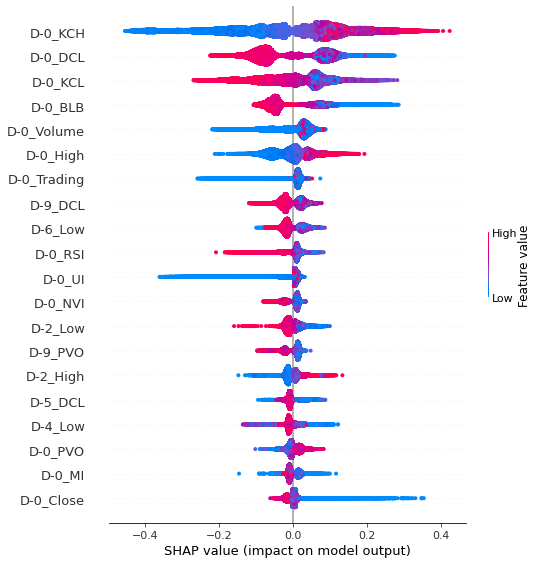

In [38]:
shap.summary_plot(shap_values, df_trainX)

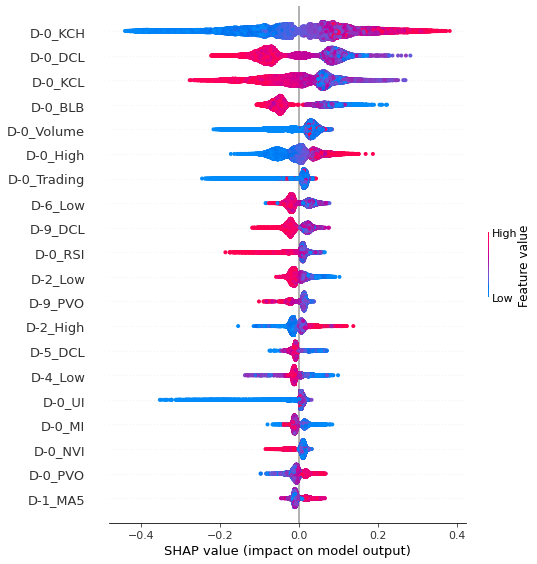

In [49]:
shap.summary_plot(shap_values_test, df_testX)

--------------

# Tree Plot 

- xgb model 의 max_deqpth를 3으로 지정 

## origin data
- shap value tree plot과 비교를 위하여 생성

<AxesSubplot:>

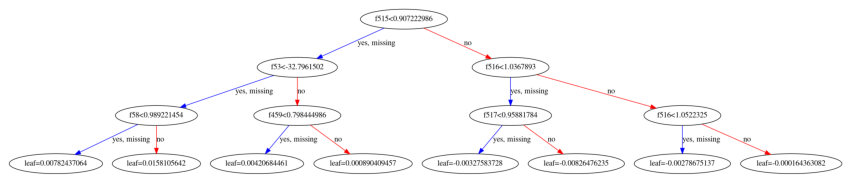

In [42]:
from xgboost import plot_tree

plot_tree(xgb_model)

---------

## shap value data

In [24]:
from xgboost import XGBClassifier

xgb_model_shap = XGBClassifier(
                   n_jobs=40,
                   scale_pos_weight=4,
                   learning_rate=0.01,
                   max_depth=3,
                   n_estimators=800,
                   ) # 임의의 값 (튜닝값 x)

xgb_model_shap.fit(df_shap, trainY)

[21:12:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=800, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

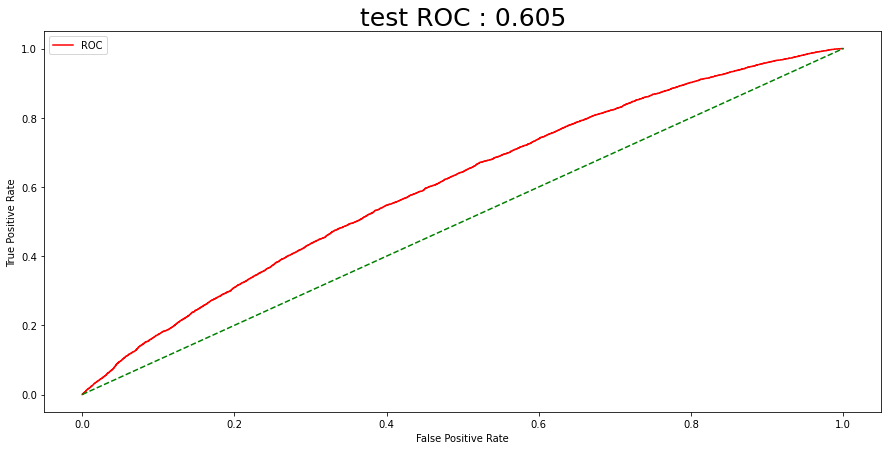

train_f1 score:  0.4414713345280976
test_f1 score:  0.26551977062079085 

train_recall score:  0.5813084112149532
test_recall score:  0.35496523444464256 

train_pre score:  0.35586577795577423
test_pre score:  0.21207925010651896 

train acc score:  0.7447555566367448
test acc score:  0.7013691202385793 



In [25]:
train_prob = xgb_model_shap.predict_proba(df_shap)[:, 1]
train_pred = xgb_model_shap.predict(df_shap)
test_prob = xgb_model_shap.predict_proba(df_shap_test)[:, 1]
test_pred = xgb_model_shap.predict(df_shap_test)

plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob)

<AxesSubplot:>

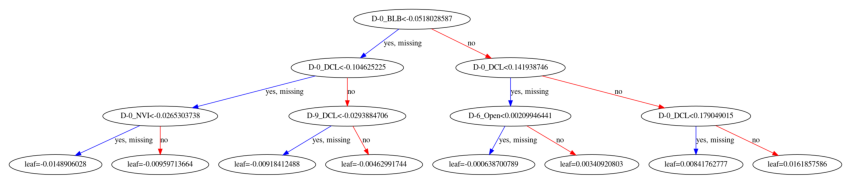

In [26]:
from xgboost import plot_tree

plot_tree(xgb_model_shap)

- 가장 오른쪽 조건 ((df_shap['D-0_BLB']>-0.0518) & (df_shap['D-0_DCL']>0.1419) & (df_shap['D-0_DCL']>0.179)) 의 데이터 확인 

In [55]:
print('total label: ', len(trainY[(df_shap['D-0_BLB']>-0.0518) & (df_shap['D-0_DCL']>0.1419) & (df_shap['D-0_DCL']>0.179)]))
print('trainY label 1: ', (trainY[(df_shap['D-0_BLB']>-0.0518) & (df_shap['D-0_DCL']>0.1419) & (df_shap['D-0_DCL']>0.179)]==1).sum())
print('train pred label 1 (xgb pred): ', (train_pred[(df_shap['D-0_BLB']>-0.0518) & (df_shap['D-0_DCL']>0.1419) & (df_shap['D-0_DCL']>0.179)]==1).sum())

total label:  1038
trainY label 1:  730
train pred label 1 (xgb pred):  1014


In [59]:
df_shap_cd =  df_trainX_cd[(df_shap['D-0_BLB']>-0.0518) & (df_shap['D-0_DCL']>0.1419) & (df_shap['D-0_DCL']>0.179)]
df_shap_cd

,Code,Date,D-9_Open,D-9_High,D-9_Low,D-9_Close,D-9_Trading,D-9_MA5,D-9_MA20,D-9_MA60,D-9_MA120,D-9_VMAP,D-9_BHB,D-9_BLB,D-9_KCH,D-9_KCL,D-9_KCM,D-9_DCH,D-9_DCL,D-9_DCM,D-9_SMA,D-9_EMA,D-9_WMA,D-9_Ichimoku,D-9_Parabolic SAR,D-9_KAMA,D-9_MACD,D-9_Change,D-9_Volume,D-9_MFI,D-9_ADI,D-9_OBV,D-9_CMF,D-9_FI,D-9_EOM_EMV,D-9_VPT,D-9_NVI,D-9_ATR,D-9_UI,D-9_ADX,D-9_-VI,D-9_+VI,D-9_TRIX,D-9_MI,D-9_CCI,D-9_DPO,D-9_KST,D-9_STC,D-9_RSI,D-9_SRSI,...,D-0_MA20,D-0_MA60,D-0_MA120,D-0_VMAP,D-0_BHB,D-0_BLB,D-0_KCH,D-0_KCL,D-0_KCM,D-0_DCH,D-0_DCL,D-0_DCM,D-0_SMA,D-0_EMA,D-0_WMA,D-0_Ichimoku,D-0_Parabolic SAR,D-0_KAMA,D-0_MACD,D-0_Change,D-0_Volume,D-0_MFI,D-0_ADI,D-0_OBV,D-0_CMF,D-0_FI,D-0_EOM_EMV,D-0_VPT,D-0_NVI,D-0_ATR,D-0_UI,D-0_ADX,D-0_-VI,D-0_+VI,D-0_TRIX,D-0_MI,D-0_CCI,D-0_DPO,D-0_KST,D-0_STC,D-0_RSI,D-0_SRSI,D-0_TSI,D-0_UO,D-0_SR,D-0_WR,D-0_AO,D-0_ROC,D-0_PPO,D-0_PVO
67,050120,20200330,0.915094,1.022642,0.915094,1.003774,8.378950e+05,1.055094,1.273491,1.476132,1.598302,1.172068,1.561728,0.985253,1.357956,1.199843,1.278899,1.492453,0.915094,1.158491,1.211950,1.168735,1.096268,1.191509,1.275697,1.173752,-0.119023,0.003774,834745.0,31.593514,-5.122397e+08,927340025.0,-0.280184,-1.414019e+08,-2.355809e+07,56296.731623,51.321021,434.586778,17.949318,47.497713,1.219697,0.660606,-0.866704,26.266115,-185.279559,190.50,-202.073697,2.981298,24.625087,0.205020,...,1.049104,1.312963,1.472028,0.962509,1.362847,0.735361,1.154062,0.959618,1.056840,1.331541,0.770609,0.948029,0.935633,0.992839,0.961967,1.000000,0.985663,0.938555,-0.091658,0.053763,2833558.0,59.769817,-5.157259e+08,929011338.0,-0.256404,1.210605e+08,8.018188e+06,152341.827957,54.056239,565.198017,26.878385,39.702192,0.961066,0.870902,-1.330231,28.419113,3.173002,-764.00,-280.180539,91.248812,46.861571,1.000000,-30.226431,44.935862,63.709677,-36.290323,-1085.558824,0.000000,-8.451657,15.770158
152,095340,20200401,1.027027,1.051351,0.785135,0.800000,3.086936e+05,1.086216,1.585068,1.593671,1.465597,1.420116,2.221673,0.948462,1.738761,1.448896,1.593829,1.966216,0.785135,1.308108,1.452027,1.331567,1.170721,1.363851,1.423948,1.174430,-0.182748,-0.200000,385867.0,31.431021,-2.593450e+06,7886733.0,-0.149344,-3.124208e+08,-6.228571e+08,-127155.768921,214.229168,1164.406715,27.735943,28.283973,1.210465,0.587791,-0.606417,26.785845,-191.397772,1770.50,-193.672679,0.001456,20.176253,0.000000,...,0.999677,1.238315,1.155233,0.873324,1.509170,0.490185,1.113190,0.894695,1.003943,1.494624,0.624731,0.876882,0.826613,0.922335,0.890729,0.976075,0.832932,0.842076,-0.110821,-0.004301,496298.0,53.464079,-1.774770e+06,9025904.0,-0.025915,2.945024e+07,2.002023e+08,32929.667965,211.966370,1054.154955,40.476341,31.242146,1.045398,0.841418,-1.663685,25.184237,9.095503,-867.00,-379.947468,75.000003,47.288893,0.991428,-24.435397,52.484634,73.560768,-26.439232,-2660.441176,6.928406,-10.726493,5.409333
154,095340,20200403,0.889831,0.967514,0.889831,0.939266,2.177734e+05,1.002260,1.558051,1.653625,1.525706,1.376691,2.304116,0.811986,1.720245,1.410499,1.565372,2.055085,0.820621,1.321328,1.359110,1.271140,1.073635,1.413136,1.247940,1.131675,-0.223982,-0.060734,231855.0,25.309226,-2.260913e+06,8131339.0,-0.104044,-1.760992e+08,-2.727998e+07,79279.012368,201.218075,1156.554770,33.117158,32.943248,1.303326,0.557913,-1.012038,26.465446,-130.470425,2369.00,-276.098467,0.000364,28.063529,0.218207,...,0.935933,1.211960,1.132007,0.840130,1.337540,0.534325,1.048613,0.832069,0.940341,1.385669,0.612223,0.885142,0.836143,0.928254,0.933287,0.971022,0.816256,0.894578,-0.081033,-0.018967,176721.0,65.196880,-1.551381e+06,9249720.0,-0.013012,2.837309e+07,4.425054e+07,6596.616958,213.110896,1000.623405,38.375978,27.517306,1.018169,0.962936,-1.559891,24.966650,19.148241,-2962.00,-340.640774,93.750001,47.660658,0.958478,-19.083829,53.692800,74.626866,-25.373134,-1697.941176,25.810811,-8.028737,0.244640
257,067290,20200330,0.920745,1.025576,0.920745,1.018945,4.012821e+05,1.080392,1.238996,1.318609,1.313628,1.252083,1.466424,1.011567,1.329849,1.160

In [60]:
df_shap_cd['Date'].value_counts()  # 2020년 3~4월에 집중되어 있음 

20200401    361
20200403    302
20200330    133
20200406     93
20200402     42
20200327     19
20200326     11
20181107      4
20190820      4
20190816      3
20200407      3
20201106      2
20190829      2
20200518      2
20190830      2
20180731      2
20200519      2
20181112      2
20190826      2
20190823      2
20200904      1
20200827      1
20171109      1
20181123      1
20170216      1
20200604      1
20181116      1
20190620      1
20200907      1
20191217      1
20191219      1
20190403      1
20200408      1
20171027      1
20180417      1
20170217      1
20170220      1
20191018      1
20181228      1
20181109      1
20180423      1
20170317      1
20170802      1
20190329      1
20171102      1
20200331      1
20170215      1
20180306      1
20201016      1
20180226      1
20180219      1
20200508      1
20200514      1
20200902      1
20190827      1
20200708      1
20200710      1
20180827      1
20190821      1
20171201      1
20190411      1
20201110      1
20190607

----------

## (cf) decision tree plot 
- xgb tree 보다 정보도 많고 예쁘지만 학습에서 xgb 모델을 사용하였으므로 비교 용으로 그려보기만 함.

https://teddylee777.github.io/visualization/Decision-Tree%EA%B0%80-%EC%96%B4%EB%96%BB%EA%B2%8C-%EB%B6%84%ED%95%A0%ED%96%88%EB%8A%94%EC%A7%80-%EC%8B%9C%EA%B0%81%ED%99%94%ED%95%98%EA%B8%B0(graphviz)

In [17]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=3, random_state=42)

# Trainmax_depth=3
model.fit(df_shap, trainY)

DecisionTreeClassifier(max_depth=3, random_state=42)

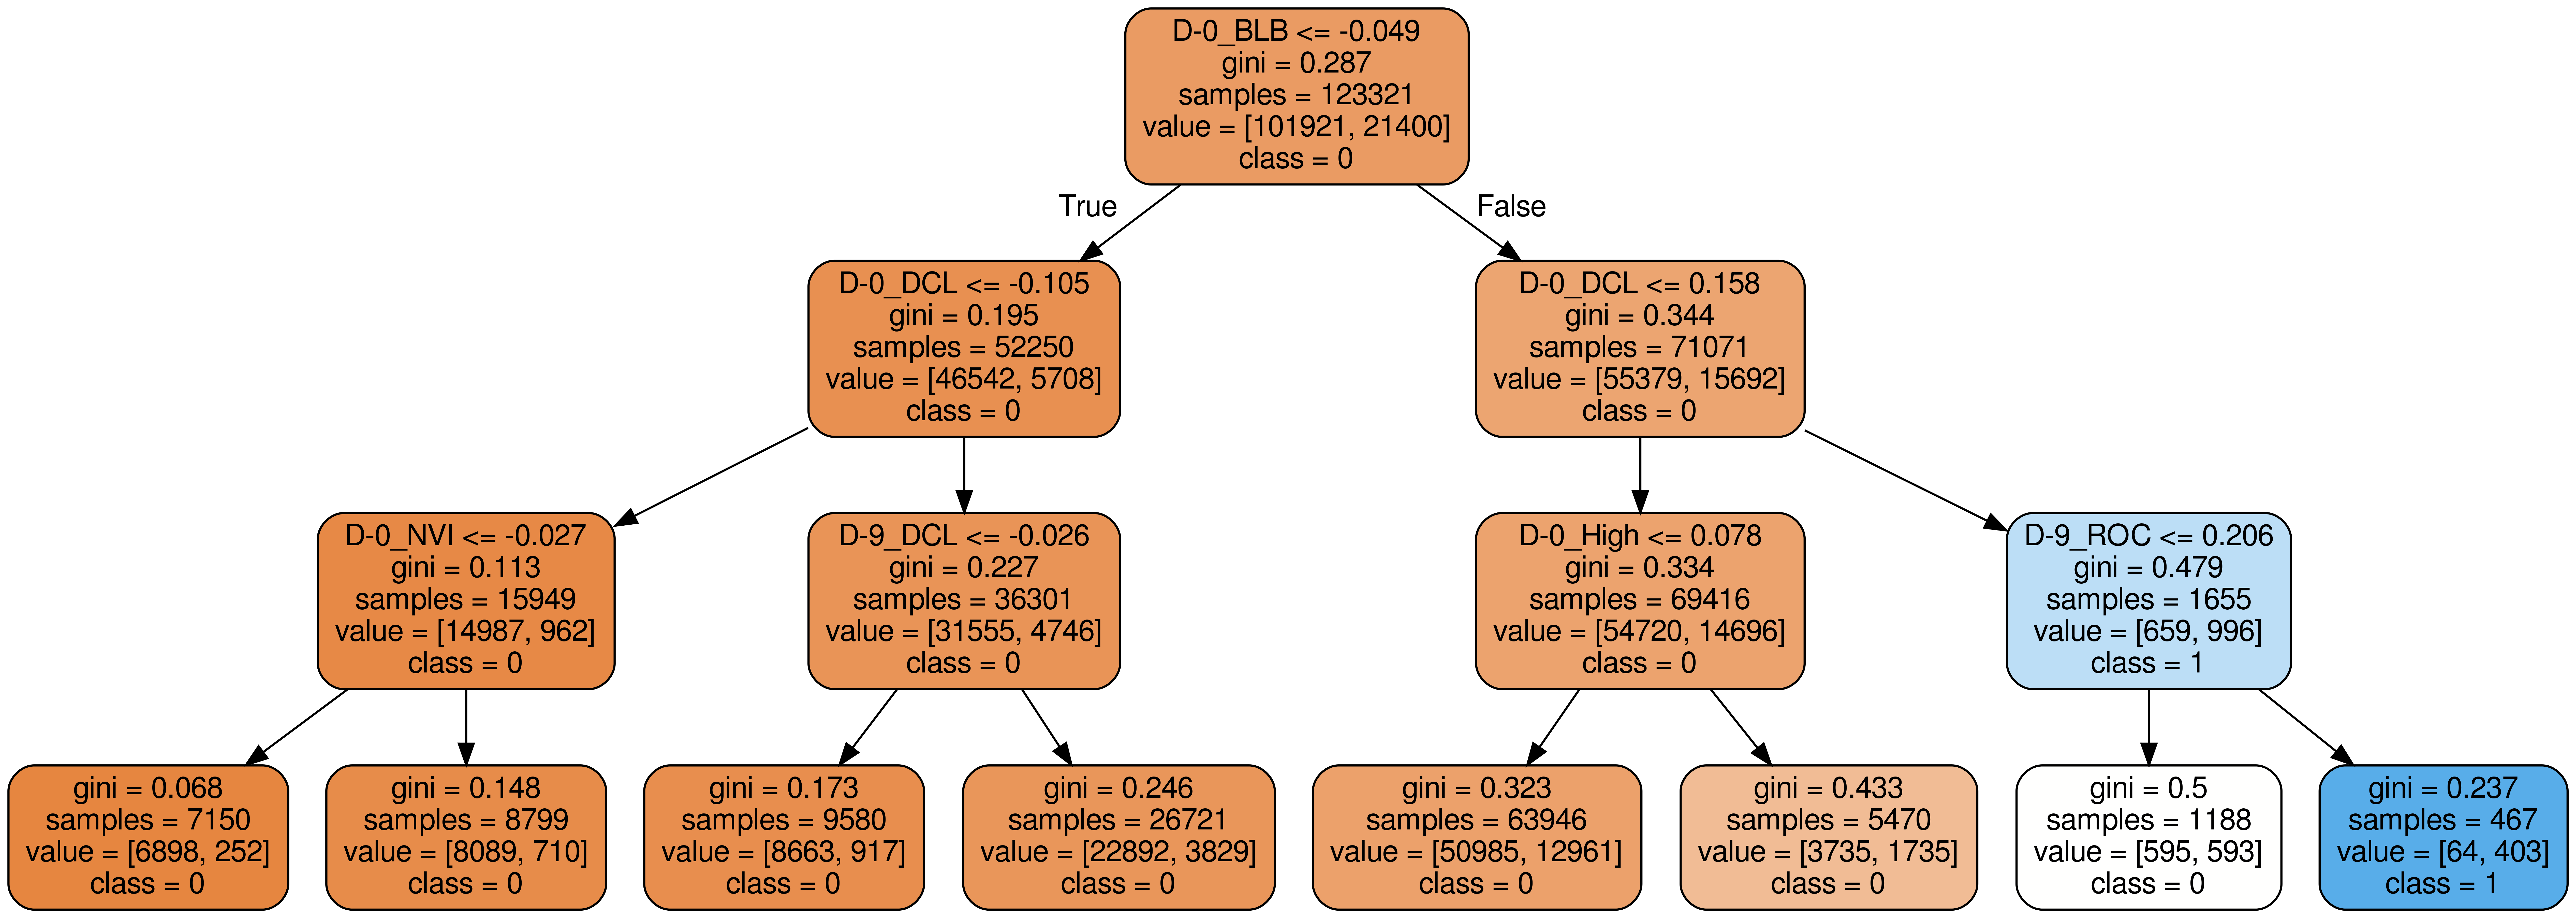

In [23]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(model, out_file='tree.dot', 
                feature_names = lst_col_info,
                class_names = ['0', '1'],
                max_depth = 3, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True, # 박스의 모양을 둥글게
               )

# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'decistion-tree.png', '-Gdpi=600'])

# jupyter notebook에서 .png 직접 출력
from IPython.display import Image
Image(filename = 'decistion-tree.png')